Forecast with disturbance: Just take a system with disturbances, learn from it, and then forecast with it.

Start with a simple periodic one-dimensional signal. Then keep increasing complexity.

In [9]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from numpy.linalg import norm
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

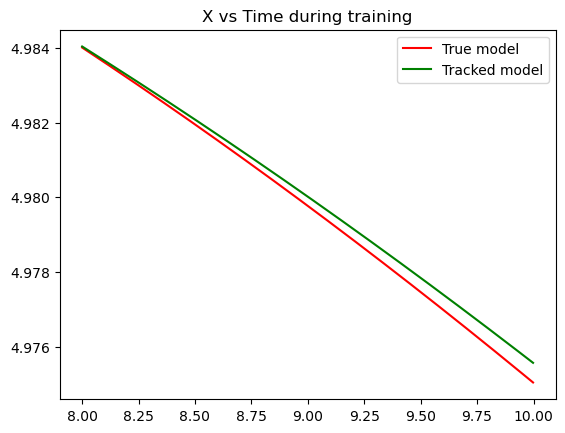

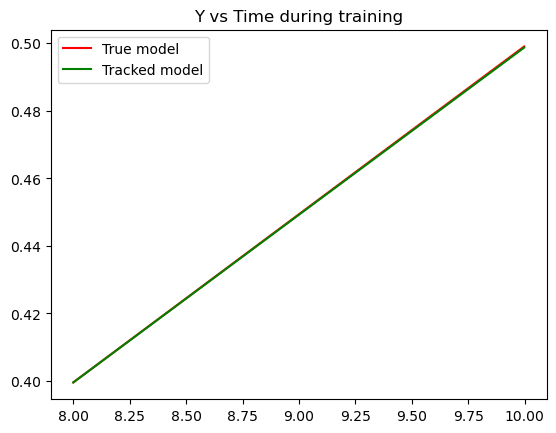

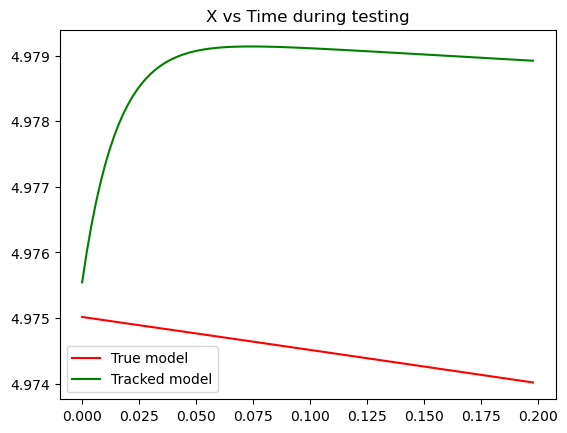

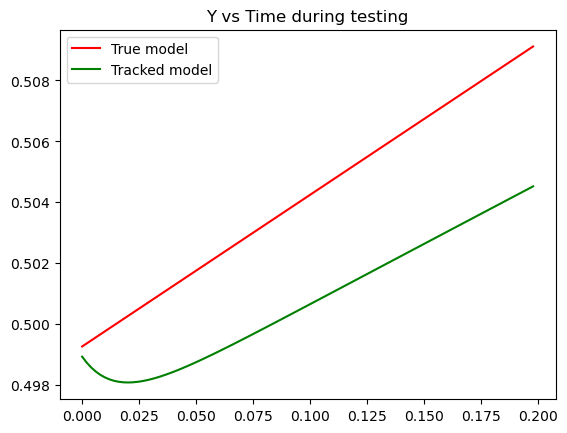

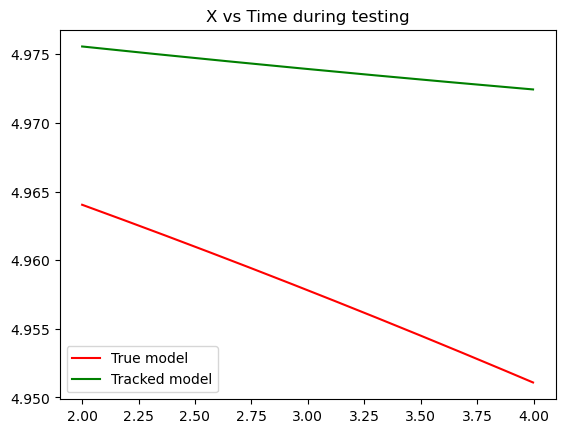

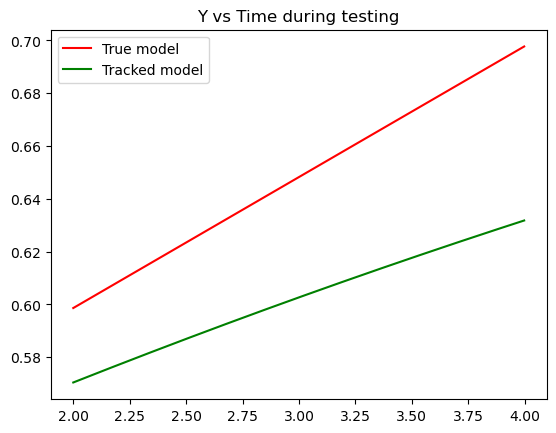

In [8]:
### Initializing parameters for training

## Reservoir parameters
n = 10                         # reservoir size
m = 2 + 1                      # number of dimensions in the system + 1 for bias term 
mu = 0.001                     # Spectral radius of reservoir adjacency matrix
lam = 0.000001                 # Lambda for ridge regression

## Simulation parameters
T = 10
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
# A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
# A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
# A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
# A = sp.csr_matrix(A1)
#A = np.zeros((n, n))

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f

radius = 5
freq = 0.01

x, y = radius, 0

R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
r = 0.5 - 1.0 * np.random.rand(n)

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, 1])
    R[:, t] = r
    
    x = x - dt * radius * freq * np.sin(freq * dt * t)
    y = y + dt * radius * freq * np.cos(freq * dt * t)

    r = np.tanh(Win.dot(u))
    f[:, t] = u


## Using only last 10000 data points for training
#f = f[:, -10000:] 
#R = R[:, -10000:]


## Finding Wout matrix using ridge regression
Wout = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  

### Plotting training data

plottimerange = np.arange(ntraining - 1000, ntraining)

plt.figure()
plt.plot(trainingtimes[plottimerange], f[0, plottimerange], 'r', label = 'True model')
plt.plot(trainingtimes[plottimerange], Wout.dot(R[:, plottimerange])[0],  'g', label = 'Tracked model')
plt.legend()
plt.title("X vs Time during training")
plt.show()

plt.figure()
plt.plot(trainingtimes[plottimerange], f[1, plottimerange], 'r', label = 'True model')
plt.plot(trainingtimes[plottimerange], Wout.dot(R[:, plottimerange])[1],  'g', label = 'Tracked model')
plt.legend()
plt.title("Y vs Time during training")
plt.show()

### Testing

## Initializing testing parameters
Ttest = 200
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)


## For storing x, y, z time series data of actual system
xpid = np.zeros(ntest + 1)             
ypid = np.zeros(ntest + 1)


## For storing error time series data
err = np.zeros(ntest)

xxpure, yypure = x, y
xxpid, yypid = x, y
xpid[0], ypid[0] = x, y
xtrack, ytrack = x, y

## Time evolution
for t in range(ntest):

    ## Ideal system
  

    xxpure = xxpure - dt * radius * freq * np.sin(freq * dt * (t + ntraining))
    yypure = yypure + dt * radius * freq * np.cos(freq * dt * (t + ntraining))

    xpure[t] = xxpure
    ypure[t] = yypure
   

    ## Actual system
    
    
    r = np.tanh(Win.dot(np.array([xtrack, ytrack, 1])))
    xtrack, ytrack = Wout.dot(r)[0: m - 1]

    xpid[t] = xtrack
    ypid[t] = ytrack




# plt.figure()
# ax = plt.axes(projection = '3d')
# ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'True model')
# ax.plot3D(xpid, ypid, zpid, 'g', linewidth = 0.1, label = 'Tracked model')
# plt.legend()
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.show()

## Finding distance between tracked and true model at each time instant and averaging it
#avgtimedist = np.mean(np.sqrt((xpure - xpid[:ntest])**2 + (ypure - ypid[:ntest])**2 + (zpure - zpid[:ntest])**2))

#print('Average of distances calculated at each instant:', avgtimedist)


## Finding distance between tracked and true model by finding the minimum distance between the two time series
# A = np.array([xpure[-5000:], ypure[-5000:], zpure[-5000:]])
# B = np.array([xpid[-5000:], ypid[-5000:], zpid[-5000:]])
# avgdist = np.mean(norm(A[:, :, None] - B[:, None, :], axis=0).min(axis=0))
# print('Average of minimum distances:', avgdist)

plottimerange = np.arange(0, 100)

plt.figure()
plt.plot(testingtimes[plottimerange], xpure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], xpid[plottimerange],  'g', label = 'Tracked model')
plt.title("X vs Time during testing")
plt.legend()
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], ypure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ypid[plottimerange],  'g', label = 'Tracked model')
plt.title("Y vs Time during testing")
plt.legend()
plt.show()

plottimerange = np.arange(1000, 2000)

plt.figure()
plt.plot(testingtimes[plottimerange], xpure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], xpid[plottimerange],  'g', label = 'Tracked model')
plt.legend()
plt.title("X vs Time during testing")
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], ypure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ypid[plottimerange],  'g', label = 'Tracked model')
plt.title("Y vs Time during testing")
plt.legend()
plt.show()

totaltimes = np.concatenate((trainingtimes, testingtimes[1:] + T))

## Plotting x and y time series similar to the above plot but with both training and testing data




Forecasting periodic Lorenz

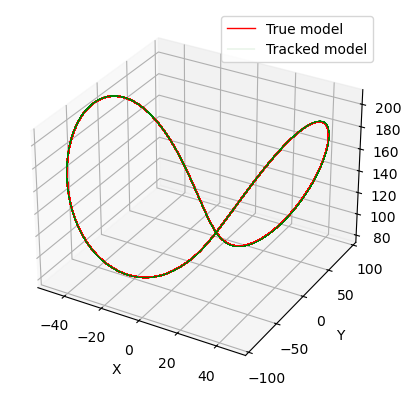

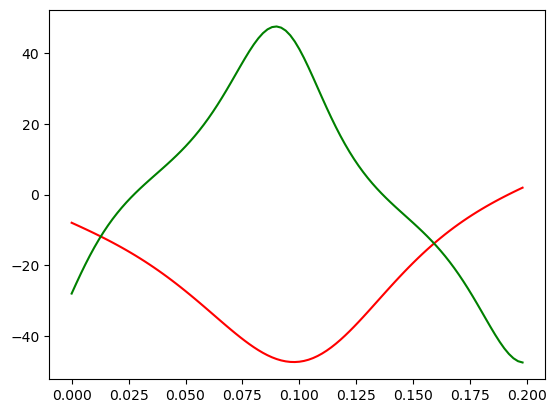

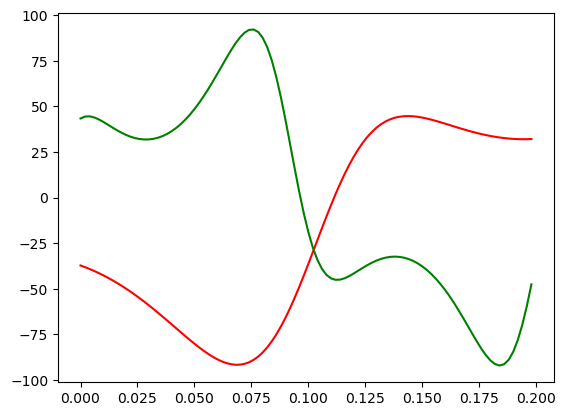

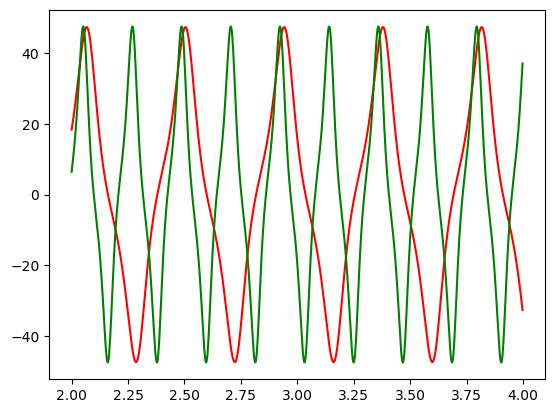

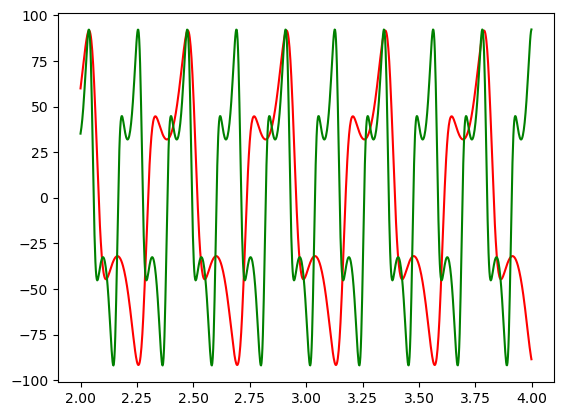

In [39]:
### Initializing parameters for training

## Lorenz system parameters 
sigma = 10
rho = 140
beta = 6

## Reservoir parameters
n = 1000                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1                      # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Simulation parameters
T = 20
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
rpid = 0.5 - 1.0 * np.random.rand(n)
rorig = rpid

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = rpid
    

    xp = sigma * (y - x)
    yp = x * (rho - z) - y 
    zp = x * y - beta * z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    rpid = np.tanh(Win.dot(u) + 1)
    f[:, t] = np.array([x, y, z])




## Using only last 10000 data points for training
f = f[:, -10000:] 
R = R[:, -10000:]


## Finding Wout matrix using ridge regression
Wout_pid = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  


# x, y, z = -7.45, -3.03, 0.01
# rpid = rorig
# xpredtrain = np.zeros(ntraining)
# ypredtrain = np.zeros(ntraining)
# zpredtrain = np.zeros(ntraining)

# for t in range(ntraining):

#     xpredtrain[t], ypredtrain[t], zpredtrain[t] = Wout_pid.dot(R[:, t])


# plottimerange = np.arange(0, 100)

# plt.figure()
# plt.plot(trainingtimes[plottimerange], f[0, plottimerange], 'r', label = 'True model')
# plt.plot(trainingtimes[plottimerange], xpredtrain[plottimerange],  'g', label = 'Tracked model')
# plt.show()


# plt.figure()
# plt.plot(trainingtimes[plottimerange], f[1, plottimerange], 'r', label = 'True model')
# plt.plot(trainingtimes[plottimerange], ypredtrain[plottimerange],  'g', label = 'Tracked model')
# plt.show()


# plottimerange = np.arange(1000, 2000)

# plt.figure()
# plt.plot(trainingtimes[plottimerange], f[0, plottimerange], 'r', label = 'True model')
# plt.plot(trainingtimes[plottimerange], xpredtrain[plottimerange],  'g', label = 'Tracked model')
# plt.show()


# plt.figure()
# plt.plot(trainingtimes[plottimerange], f[1, plottimerange], 'r', label = 'True model')
# plt.plot(trainingtimes[plottimerange], ypredtrain[plottimerange],  'g', label = 'Tracked model')
# plt.show()


### Testing

## Initializing testing parameters
Ttest = 200
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)

## For storing x, y, z time series data of actual system
xpid = np.zeros(ntest)             
ypid = np.zeros(ntest)
zpid = np.zeros(ntest)

## For storing error time series data
err = np.zeros(ntest)

xxpure, yypure, zzpure = x, y, z
xxpid, yypid, zzpid = x, y, z

xxtrack = np.zeros(ntest)             
yytrack = np.zeros(ntest)
zztrack = np.zeros(ntest)

## Time evolution
for t in range(ntest):

    ## Ideal system
    xxpurep = sigma * (yypure - xxpure)
    yypurep = xxpure * (rho - zzpure) - yypure
    zzpurep = xxpure * yypure - beta * zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure   

    ## Actual system
    
    rpid = np.tanh(Win.dot(np.array([xtrack, ytrack, ztrack])) + np.ones(n))
    xtrack, ytrack, ztrack = Wout_pid.dot(rpid)
    
    
    

    xpid[t] = xtrack
    ypid[t] = ytrack
    zpid[t] = ztrack





plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 1, label = 'True model')
ax.plot3D(xpid, ypid, zpid, 'g', linewidth = 0.1, label = 'Tracked model')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

plottimerange = np.arange(0, 100)

plt.figure()
plt.plot(testingtimes[plottimerange], xpure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], xpid[plottimerange],  'g', label = 'Tracked model')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], ypure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ypid[plottimerange],  'g', label = 'Tracked model')
plt.show()

plottimerange = np.arange(1000, 2000)

plt.figure()
plt.plot(testingtimes[plottimerange], xpure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], xpid[plottimerange],  'g', label = 'Tracked model')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], ypure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ypid[plottimerange],  'g', label = 'Tracked model')
plt.show()

In [34]:
xpid

array([nan, nan, nan, ..., nan, nan, nan])

Trying with dt = 0.001

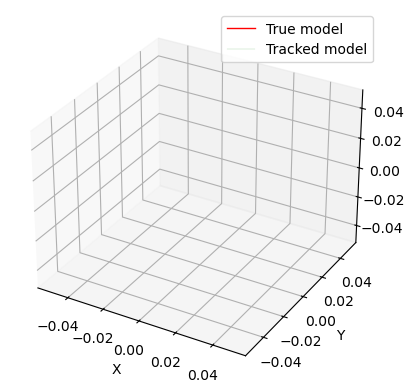

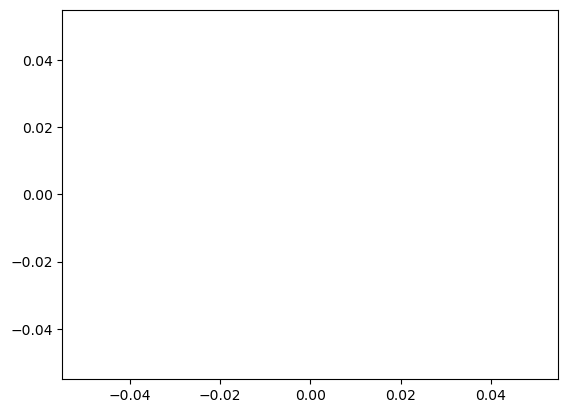

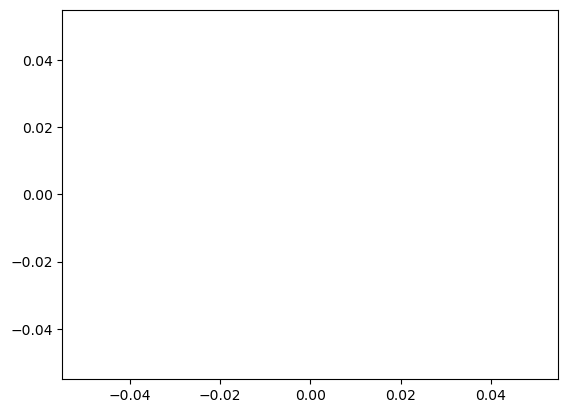

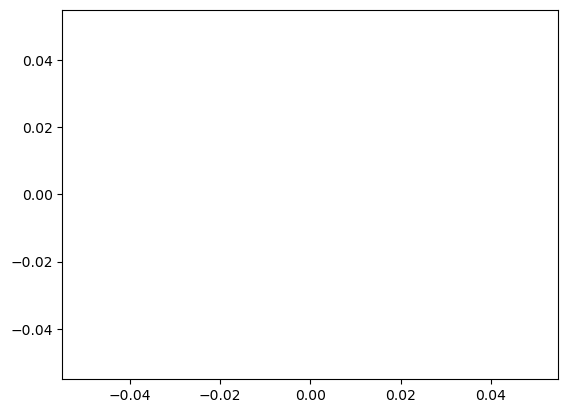

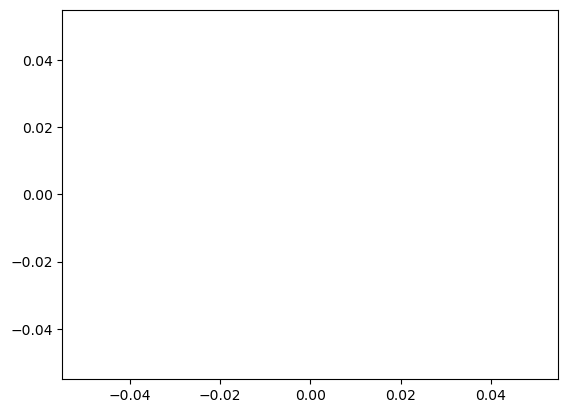

In [41]:
### Initializing parameters for training

## Lorenz system parameters 
sigma = 10
rho = 140
beta = 6

## Reservoir parameters
n = 1000                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1                      # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Simulation parameters
T = 20
dt = 0.005
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
rpid = 0.5 - 1.0 * np.random.rand(n)
rorig = rpid

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = rpid
    

    xp = sigma * (y - x)
    yp = x * (rho - z) - y 
    zp = x * y - beta * z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    rpid = np.tanh(Win.dot(u) + 1)
    f[:, t] = np.array([x, y, z])




## Using only last 10000 data points for training
f = f[:, -10000:] 
R = R[:, -10000:]

## Adding gaussian noise to the data
f = f + np.random.normal(0, 0.005, f.shape)

## Finding Wout matrix using ridge regression
Wout_pid = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  


# x, y, z = -7.45, -3.03, 0.01
# rpid = rorig
# xpredtrain = np.zeros(ntraining)
# ypredtrain = np.zeros(ntraining)
# zpredtrain = np.zeros(ntraining)

# for t in range(ntraining):

#     xpredtrain[t], ypredtrain[t], zpredtrain[t] = Wout_pid.dot(R[:, t])


# plottimerange = np.arange(0, 100)

# plt.figure()
# plt.plot(trainingtimes[plottimerange], f[0, plottimerange], 'r', label = 'True model')
# plt.plot(trainingtimes[plottimerange], xpredtrain[plottimerange],  'g', label = 'Tracked model')
# plt.show()


# plt.figure()
# plt.plot(trainingtimes[plottimerange], f[1, plottimerange], 'r', label = 'True model')
# plt.plot(trainingtimes[plottimerange], ypredtrain[plottimerange],  'g', label = 'Tracked model')
# plt.show()


# plottimerange = np.arange(1000, 2000)

# plt.figure()
# plt.plot(trainingtimes[plottimerange], f[0, plottimerange], 'r', label = 'True model')
# plt.plot(trainingtimes[plottimerange], xpredtrain[plottimerange],  'g', label = 'Tracked model')
# plt.show()


# plt.figure()
# plt.plot(trainingtimes[plottimerange], f[1, plottimerange], 'r', label = 'True model')
# plt.plot(trainingtimes[plottimerange], ypredtrain[plottimerange],  'g', label = 'Tracked model')
# plt.show()


### Testing

## Initializing testing parameters
Ttest = 200
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)

## For storing x, y, z time series data of actual system
xpid = np.zeros(ntest)             
ypid = np.zeros(ntest)
zpid = np.zeros(ntest)

## For storing error time series data
err = np.zeros(ntest)

xxpure, yypure, zzpure = x, y, z
xxpid, yypid, zzpid = x, y, z

xxtrack = np.zeros(ntest)             
yytrack = np.zeros(ntest)
zztrack = np.zeros(ntest)

## Time evolution
for t in range(ntest):

    ## Ideal system
    xxpurep = sigma * (yypure - xxpure)
    yypurep = xxpure * (rho - zzpure) - yypure
    zzpurep = xxpure * yypure - beta * zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure   

    ## Actual system
    xtrack, ytrack, ztrack = Wout_pid.dot(rpid)
    rpid = np.tanh(Win.dot(np.array([xtrack, ytrack, ztrack])) + 1)

    xpid[t] = xtrack
    ypid[t] = ytrack
    zpid[t] = ztrack





plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 1, label = 'True model')
ax.plot3D(xpid, ypid, zpid, 'g', linewidth = 0.1, label = 'Tracked model')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

plottimerange = np.arange(0, 100)

plt.figure()
plt.plot(testingtimes[plottimerange], xpure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], xpid[plottimerange],  'g', label = 'Tracked model')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], ypure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ypid[plottimerange],  'g', label = 'Tracked model')
plt.show()

plottimerange = np.arange(1000, 2000)

plt.figure()
plt.plot(testingtimes[plottimerange], xpure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], xpid[plottimerange],  'g', label = 'Tracked model')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], ypure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ypid[plottimerange],  'g', label = 'Tracked model')
plt.show()

In [30]:
f[0, :]

array([-7.23023597, -7.28530556, -7.5825665 , ...,         nan,
               nan,         nan])